# モジュールインストール

In [ ]:
!pip install -r requirements.txt

# StreamlitアクセスURL

In [ ]:
https://k-nagayama-hnx0.notebook.ap-northeast-1.sagemaker.aws/proxy/8501/

In [ ]:
import webbrowser

url = 'https://k-nagayama-hnx0.notebook.ap-northeast-1.sagemaker.aws/proxy/8501/'
webbrowser.open_new_tab(url)

## imgsフォルダをS3と同期する
**アップロード**

In [ ]:
!aws s3 sync imgs s3://trolley-monitor/imgs --exact-timestamps --delete

## imgsフォルダをS3と同期する
**ダウンロード**

In [ ]:
!aws s3 sync s3://trolley-monitor/imgs imgs --exact-timestamps

# black, flake8によるコードチェック
## コードの自動フォーマット

In [ ]:
!pwd

In [ ]:
!pip install flake8

In [ ]:
!black ./pages/1_⚡_TTS摩耗判定システム.py

## コーディング規約のチェック
https://flake8.pycqa.org/en/2.6.0/warnings.html

In [ ]:
!flake8 ./pages/1_⚡_TTS摩耗判定システム.py --max-line-length 200

In [ ]:
!flake8 utils_01.py --max-line-length 200

In [ ]:
!flake8 utilsS3_01.py --max-line-length 200

# 作業用

In [1]:
import boto3
import os
import shelve
import streamlit as st
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import pandas as pd
# import src.utilsST_01 as utlst
import src.helpers as helpers
import src.visualize as vis
from src.config import appProperties
from src.trolley import trolley
from src.similar_pixel import pixel

config = appProperties('config.yml')

2023-04-26 00:42:57.634 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


In [2]:
images_path = helpers.list_imagespath(config.image_dir)
dir_area = "Chuo_01_Tokyo-St_up_20230201_knight"
camera_num = "HD32"
target_dir = config.image_dir + "/" + dir_area + "/" + camera_num
outpath = config.output_dir + "/" + dir_area + "/" + camera_num
outpath = config.output_dir + "/" + dir_area + "/" + camera_num
os.makedirs(outpath, exist_ok=True)

rail = shelve.open(outpath + "/rail.shelve", writeback=True)
rail["inpath"] = dir_area

base_images = helpers.list_images(target_dir)

blankdict_size = [{}] * len(base_images)
rail[camera_num] = dict(zip(base_images, blankdict_size))

# ここまでを出力
print(f'images_path     :{images_path}')
print(f'dir_area        :{dir_area}')
print(f'target_dir      :{target_dir}')
print(f'outpath         :{outpath}')
print(f'len(base_images):{len(base_images)}')


images_path     :['Chuo_01_Tokyo-St_up_20230201_knight', 'Chuo_02_Tokyo-Kanda_up_20230201_knight', 'Chuo_03_Kanda-St_up_20230201_knight', 'Chuo_04_Kanda-Ochanomizu_up_20230201_knight', 'Chuo_05_Ochanomizu-St_up_20230201_knight', 'Chuo_06_Ochanomizu-Suidobashi_up_20230201_knight', 'Chuo_07_Suidobashi-St_up_20230201_knight', 'Chuo_08_Suidobashi-Iidabashi_up_20230201_knight', 'Chuo_09_Iidabashi-St_up_20230201_knight', 'Chuo_10_Iidabashi-Ichigaya_up_20230201_knight', 'Chuo_11_Ichigaya-St_up_20230201_knight', 'Chuo_12_Ichigaya-Yotsuya_up_20230201_knight', 'Chuo_13_Yotsuya-St_up_20230201_knight', 'Chuo_14_Yotsuya-Shinanomachi_up_20230201_knight', 'Chuo_15_Shinanomachi-St_up_20230201_knight', 'Chuo_16_Shinanomachi-Sendagaya_up_20230201_knight', 'Chuo_17_Sendagaya-St_up_20230201_knight', 'Chuo_18_Sendagaya-Yoyogi_up_20230201_knight', 'Chuo_19_Shinjuku-St_up_20230201_knight', 'Kawagoe_01_Omiya-Nisshin_down_20210721_knight', 'Kawagoe_02_Nishioomiya-Sashiougi_down_20220626_knight', 'Kawagoe_02_Sa

In [3]:
keys = rail.keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: inpath
1: HD32


In [12]:
rail[camera_num][image_path]

NameError: name 'image_path' is not defined

In [4]:
# 読み込まれたデータを確認したいときに実行する
infile_path = list(rail[camera_num].keys())
infile_path.sort()
for i, key in enumerate(keys):
    print(f"{i}: {key}")
# rail[camera_num][0]

infile_path[0]

0: inpath
1: HD32


'imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD32/2022_0615_HD32_01_00022313.jpg'

In [5]:
dir_name = config.image_dir + '/' + dir_area
helpers.print_files(dir_name, dir_area, camera_num)

output file is: imgs/Chuo_01_Tokyo-St_up_20230201_knighttemp_meta.csv


In [6]:
test_num = 0
global_ix = 250000

idx = 0

In [7]:
file = infile_path[idx]
file

'imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD32/2022_0615_HD32_01_00022313.jpg'

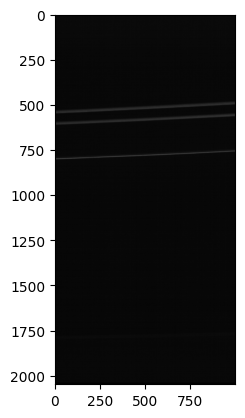

In [8]:
pixel_instance1 = pixel(1, 0, 0)
pixel_instance2 = pixel(2, 0, 0)
pixel_instance3 = pixel(3, 0, 0)
pixel_instance1.isInFrame = True
pixel_instance2.isInFrame = False
pixel_instance3.isInFrame = False

pixel_instance1.load_picture(file)
pixel_instance2.load_picture(file)
pixel_instance3.load_picture(file)

img = pixel_instance1.picture['im_org']
plt.imshow(img)
plt.show()

In [9]:
# 初期位置の自動サーチ
search_list = pixel_instance1.search_trolley_init(idx)
search_list

[[799, 804, 1]]

In [10]:
# 初期値の設定
xin = None
if search_list != []:
    auto_edge = True
else:
    auto_edge = False
print(f'xin={xin}, auto_edge:{auto_edge}')

xin=None, auto_edge:True


In [11]:
pixel_instance1.set_init_val(rail, idx, img, search_list, auto_edge)

IndexError: list assignment index out of range

In [ ]:
images_path[0]

In [ ]:
target_dir + "/" + images_path[0] + ".jpg"
# 'imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD32/2022_0615_HD32_01_00022313.jpg'

In [ ]:
# rail['HD32'][target_dir + "/" + images_path[0]]
rail['HD32']['imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD32/2022_0615_HD32_01_00022313.jpg']

In [ ]:
rail['name']

In [ ]:
rail['HD22']['imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD22/2022_0615_HD22_01_00022472.jpg']

In [ ]:
rail['HD11']['imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg']

In [ ]:
rail.close

In [ ]:
!python src/config.py

In [ ]:
CAMERA_NUMS = ["HD11", "HD12", "HD21", "HD22", "HD31", "HD32"]
camera_names = utlst.camera_names()
camera_name_list = []
for camera_name in camera_names:
    camera_name_list.append(camera_names[camera_name])
camera_name_list

In [ ]:
CAMERA_NUMS = ["HD11", "HD12", "HD21", "HD22", "HD31", "HD32"]
camera_names = utlst.camera_names()
camera_name_list = [camera_names[camera_name] for camera_name in camera_names]
camera_name_list

In [ ]:
camera_name_list = [utlst.camera_names()[camera_name] for camera_name in utlst.camera_names()]
camera_name_list

In [ ]:
CAMERA_NUMS[camera_name_list.index('高(右)')]

In [ ]:
def camera_names():
    camera_names = {
        "HD11": "高(左)",
        "HD12": "高(右)",
        "HD21": "中(左)",
        "HD22": "中(右)",
        "HD31": "低(左)",
        "HD32": "低(右)",
}
    return camera_names

def camera_num2name(camera_num):
    camera_names_dict = camera_names()
    camera_name = camera_names_dict[camera_num]
    return camera_name

camera_name = camera_num2name('HD11')
camera_name

In [ ]:
import pathlib

def get_image_list(path):
    try:
        files = os.listdir(path)
        files_file = [f for f in files if os.path.isfile(os.path.join(path, f))]
        files_file.sort()
    except Exception as e:
        files_file = []
    return files_file

path = 'images/Chuo_19_Shinjuku-St_up_20230201_knight/HD12/'

image_list = get_image_list(path)
image_list


In [ ]:
from pathlib import Path

def get_file_list(path):
    dir_path = Path(path)
    image_obj_list = [path for path in dir_path.glob("*") if path.is_file()]
    image_list = [image_obj.name for image_obj in image_obj_list]
    image_list.sort()
    return image_list

def get_dir_list(path):
    dir_path = Path(path)
    dir_obj_list = [path for path in dir_path.glob("*") if path.is_dir() and not path.name.startswith(".")]
    dir_list = [image_obj.name for image_obj in dir_obj_list]
    dir_list.sort()
    return dir_list


path = 'images/Chuo_19_Shinjuku-St_up_20230201_knight/HD12/'
image_list = get_file_list(path)
image_list

In [ ]:
path = 'images/Chuo_19_Shinjuku-St_up_20230201_knight/HD11/'
image_list = get_file_list(path)
image_list

In [ ]:
path = 'images/'
dir_list = get_dir_list(path)
dir_list

In [ ]:
def get_dir_list(path):
    dir_path = Path(path)
    dir_obj_list = [path for path in dir_path.glob("*") if path.is_dir()]
    dir_list = [image_obj.name for image_obj in dir_obj_list]
    dir_list.sort()
    return dir_list

path = 'images/'
dir_list = get_file_list(path)
dir_list

In [ ]:
path = 'images/'
dir_path = Path(path).glob("*")
for i in dir_path:
    if i.is_dir:
        print(i)

In [ ]:
!pwd

In [ ]:
len(image_obj_list)

In [ ]:
image_list = [image_obj_list[i].name for i in range(len(image_obj_list))]
image_list

In [ ]:
s3 = boto3.resource('s3')
bucket_name = 'k-nagayama'
prefix = 'OHCImages/images/'
bucket = s3.Bucket(bucket_name)
folders_list = []

for obj in bucket.objects.filter(Prefix=prefix, Delimiter='/'):
    folders_list.append(obj.key)

folders_list

In [ ]:
path='OHCImages/images/'

# def test(path):
s3 = boto3.client('s3')
images_path = []
response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path, Delimiter='/')
for content in response.get('CommonPrefixes', []):
    full_path = content.get('Prefix')
    normalized_path = os.path.normpath(full_path)
    images_path.append(os.path.basename(normalized_path))
images_path.sort()
images_path
# print(f'normalized_path type -> {type(normalized_path)}')

In [ ]:
['Chuo_Suidobashi-Iidabashi_down',
 'Chuo_Suidobashi-Iidabashi_up',
 'Kawagoe_Sashiougi-Minamifuruya',
 'Nishioomiya-Sashiougi_20220626',
 'Ohmiya-Miyahara_down_20220221',
 'Omiya-Nisshin_down_20210721',
 'Sashiougi-Minamifuruya_20220626',
 'Sashiougi_20220626']

In [ ]:
path = "OHCImages/images/Chuo_Suidobashi-Iidabashi_down/"
normalized_path = os.path.normpath(path)
last_dirname = os.path.basename(normalized_path)
last_dirname

In [ ]:
# S3オブジェクト数1000件までしか対応できず
s3 = boto3.client('s3')
path = 'OHCImages/images/Kawagoe_Sashiougi-Minamifuruya/HD21/'
file_list = []

# S3バケット内のファイル一覧を取得
response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path)
for content in response.get('Contents', []):
    file_list.append(content.get('Key'))
response  #["ResponseMetadata"]

In [ ]:
s3 = boto3.client('s3')
path = 'OHCImages/images/Kawagoe_Sashiougi-Minamifuruya/HD21/'
file_list = []

# S3バケット内のファイル一覧を取得
response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path)
for content in response.get('Contents', []):
    file_list.append(content.get('Key'))

# レスポンスが1000件未満になるまでリクエストを続ける
while response['IsTruncated']:
    response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path, ContinuationToken=response['NextContinuationToken'])
    for content in response.get('Contents', []):
        file_list.append(content.get('Key'))
len(file_list)

In [ ]:
s3 = boto3.resource("s3")
bucket = s3.Bucket('k-nagayama')
prefix = 'OHCImages/images/Kawagoe_Sashiougi-Minamifuruya/HD22/'


def get_all_keys(bucket_name: str, prefix: str, keys: list[str], marker: str) -> list[str]:
    """
    S3の指定したパスに存在するオブジェクトのキーを全て取得する

    Parameters
    ----------
    bucket_name: String
        対象のBucket
    prefix: String
        対象のディレクトリのパス
    keys: list[str]
    marker: String
        関数の中から呼び出す時のための引数。通常はkeys = [], marker = "" で呼び出す

    Returns
    -------
    list[str]
        取得したキーのリスト
    """
    s3 = boto3.resource("s3")
    bucket = s3.Bucket(bucket_name)
    objects = bucket.meta.client.list_objects_v2(Bucket=bucket.name, Prefix=prefix, StartAfter=marker)
    if "Contents" in objects:
        keys.extend([content["Key"] for content in objects["Contents"]])
        print(f'isTruncated:{objects.get("isTruncated")}')
        # 返り値のIsTruncatedがTrueかどうかを確認する
        if objects.get("isTruncated"):
            # marker引数に取得したkeysの末尾の値を設定して再度get_all_keysを実行する
            return get_all_keys(bucket_name=bucket_name, prefix=prefix, keys=keys, marker=keys[-1])
    return keys

file_list = get_all_keys(bucket.name, prefix, [], "")
len(file_list)

In [ ]:
for i in range(1):
    print(i)
    

In [ ]:

idx = 0
path = 'OHCImages/images/Chuo_Suidobashi-Iidabashi_down/HD11/2022_0225_HD11_01_00000073.jpg'
s3 = boto3.client('s3')
response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path)
response


# print(f'{idx}番目の画像を表示します')
# im_base = Image.open(response)
# imshow(im_base, caption='車モニ画像')

In [ ]:


idx = 0
path = 'OHCImages/images/Chuo_Suidobashi-Iidabashi_down/HD11/2022_0225_HD11_01_00000073.jpg'
s3 = boto3.client('s3')
response = s3.get_object(Bucket='k-nagayama', Key=path)
image_content = response['Body'].read()
img = Image.open(BytesIO(image_content))
img.show()

In [ ]:
# S3バケットに画像を保存する

dir_path = 'OHCImages/'
file_name = 'test.jpg'
file_full_path = dir_path + file_name
img = Image.open('test.jpg')

# バイトデータに変換する
with BytesIO() as output:
    img.save(output, format="JPEG")
    contents = output.getvalue()

s3 = boto3.client('s3')
response = s3.put_object(Body=contents, Bucket='k-nagayama', Key=file_full_path)
response

In [ ]:
# S3バケットにディレクトリが無ければ作成する
def test_dir_put(dir):
    s3 = boto3.client('s3')
    result = s3.list_objects(Bucket='k-nagayama', Prefix=dir)    #ディレクトリを変数に
    if not "Contents" in result:    # ディレクトリがない場合はContents というキーが存在しない。これを使えば存在判定ができる。
        s3.put_object(Bucket='k-nagayama', Key=dir)    #ディレクトリ作成 


In [ ]:
# S3に1000件以上のディレクトリを作成する（テスト用）
base_dir = 'OHCImages/test/'    #ディレクトリパス
for i in range(1100):
    test_dir_put(base_dir + str(i) + '/')

In [ ]:
def get_s3_dir_list(path):
    s3 = boto3.client('s3')
    rail_list = []
    # S3バケット内のディレクトリ一覧を取得
    response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path, Delimiter='/')
    for content in response.get('CommonPrefixes', []):
        full_path = content.get('Prefix')
        normalized_path = os.path.normpath(full_path)
        rail_list.append(os.path.basename(normalized_path))
    # レスポンスが1000件未満になるまでリクエストを続ける
    while response['IsTruncated']:
        response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path, Delimiter='/', ContinuationToken=response['NextContinuationToken'])
        for content in response.get('CommonPrefixes', []):
            full_path = content.get('Prefix')
            normalized_path = os.path.normpath(full_path)
            rail_list.append(os.path.basename(normalized_path))
    rail_list.sort()
    return rail_list

base_dir = 'OHCImages/test/'    #ディレクトリパス

dir_list = get_s3_dir_list(base_dir)
# response
len(dir_list)

In [ ]:
# S3バケットのディレクトリ一覧を取得する
def get_s3_dir_list(path):
    s3 = boto3.client('s3')
    rail_list = []
    response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path, Delimiter='/')
    for content in response.get('CommonPrefixes', []):
        full_path = content.get('Prefix')
        normalized_path = os.path.normpath(full_path)
        rail_list.append(os.path.basename(normalized_path))
    rail_list.sort()
    return rail_list

# S3バケットのカメラフォルダ内のファイル一覧を取得する
def get_s3_image_list(path):
    s3 = boto3.client('s3')
    # path = 'OHCImages/images/Chuo_Suidobashi-Iidabashi_down/HD11/'
    image_list = []
    # S3バケット内のファイル一覧を取得
    response = s3.list_objects_v2(Bucket='k-nagayama', Prefix=path)
    for content in response.get('Contents', []):
        full_path = content.get('Key')
        image_list.append(os.path.basename(full_path))
    image_list.sort()
    return image_list

# S3バケットの電車線金具モニタリングシステムの画像を表示する
def ohc_image_load(path, idx):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket='k-nagayama', Key=path)
    image_content = response['Body'].read()
    st.text(f'{idx}番目の画像を表示します')
    img = Image.open(BytesIO(image_content))
    st.image(img, caption='車モニ画像')
    return

# S3バケットの電車線金具モニタリングシステムの画像を取得する
def get_image(path):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket='k-nagayama', Key=path)
    image_content = response['Body'].read()
    img = Image.open(BytesIO(image_content))
    return img

def put_s3_csv(csv_data, file_full_path):
    s3 = boto3.client('s3')
    response = s3.put_object(Body=csv_data, Bucket='k-nagayama', Key=file_full_path)
    return

# メタデータ作成
def print_files(dir_name, image_list, csvname, cam):
  # print_files('OHCImages/images/' + dir_area, image_list, dir_area, camera_num)
    dict = {
        "dirname":[],
        "filename":[],
        "camera_num":[],
        "upper_boundary1":[],
        "lower_boundary1":[],
        "upper_diff1":[],
        "lower_diff1":[],
        "upper_boundary2":[],
        "lower_boundary2":[],
        "upper_diff2":[],
        "lower_diff2":[],
        "upper_boundary3":[],
        "lower_boundary3":[],
        "upper_diff3":[],
        "lower_diff3":[]
    }
    for file in image_list:
        dict["dirname"].append(os.path.dirname(dir_name + '/' + cam + '/' + file))
        dict["filename"].append(os.path.basename(file))
        dict["camera_num"].append(cam)
        dict["upper_boundary1"].append(None)
        dict["lower_boundary1"].append(None)
        dict["upper_diff1"].append(None)
        dict["lower_diff1"].append(None)
        dict["upper_boundary2"].append(None)
        dict["lower_boundary2"].append(None)
        dict["upper_diff2"].append(None)
        dict["lower_diff2"].append(None)
        dict["upper_boundary3"].append(None)
        dict["lower_boundary3"].append(None)
        dict["upper_diff3"].append(None)
        dict["lower_diff3"].append(None)
    df=pd.DataFrame.from_dict(dict)
    
    csv_data = df.to_csv(index=False)
    
    put_s3_csv(csv_data, f"{dir_name}/{csvname}_temp_meta.csv")
    csv_path = f"{dir_name}/{csvname}_temp_meta.csv"
    return csv_path




# Main
CAMERA_NUMS = ['HD11','HD12','HD21','HD22','HD31','HD32']

rail_list = get_s3_dir_list('OHCImages/images/')
dir_area = rail_list[0]
camera_num = CAMERA_NUMS[0]
image_list = get_s3_image_list('OHCImages/images/' + dir_area + '/' + camera_num + '/')

# rail_list[0]
# image_list[0]

csv_path = print_files('OHCImages/images/' + dir_area, image_list, dir_area, camera_num)

# df


In [ ]:
# S3バケットのCSVファイルをPandasデータフレームとして取得する
def get_s3_csv_asDf(path):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket='k-nagayama', Key=path)
    csv_content = response['Body'].read()
    df = pd.read_csv(BytesIO(csv_content), header=0,dtype={'camera_num':str})
    return df

path = 'OHCImages/images/Chuo_Suidobashi-Iidabashi_down/Chuo_Suidobashi-Iidabashi_down_temp_meta.csv'
df = get_s3_csv_asDf(path)



In [ ]:
def get_rail(metadatafile, dir_area, CAMERA_NUMS):
    rail = { #線区ごとの情報
        'metadata_name':None,
        'upper_boundary1':[], #線区の開始点のトロリ線の上端
        'lower_boundary1':[], #線区の開始点のトロリ線の下端
        'upper_boundary2':[],
        'lower_boundary2':[],
        'upper_boundary3':[],
        'lower_boundary3':[],
        
        'df':pd.DataFrame()
    }
    df = get_s3_csv_asDf(metadatafile)
    
    outpath_list = []
    
    rail['df'] = df
    rail['metadata_name']=metadatafile
    rail['metadata_length']=len(df)
    rail['camera_num'] = df['camera_num']
    rail['inpath'] = [f'{x[0]}/{x[1]}' for x in zip(df['dirname'].tolist(), df['filename'].tolist())]
    rail['infile'] = df['filename']
    for camera_num in CAMERA_NUMS:
        outpath_list.append(f'output/{dir_area}/{camera_num}/')
    rail['outpath'] = outpath_list
    rail['upper_boundary1'] = df['upper_boundary1'].tolist()
    rail['lower_boundary1'] = df['lower_boundary1'].tolist()
    rail['upper_boundary2'] = df['upper_boundary2'].tolist()
    rail['lower_boundary2'] = df['lower_boundary2'].tolist()
    rail['upper_boundary3'] = df['upper_boundary3'].tolist()
    rail['lower_boundary3'] = df['lower_boundary3'].tolist()
    return rail.copy()

path = 'OHCImages/images/Chuo_Suidobashi-Iidabashi_down/Chuo_Suidobashi-Iidabashi_down_temp_meta.csv'
dir_area = rail_list[0]
CAMERA_NUMS = ['HD11','HD12','HD21','HD22','HD31','HD32']

rail = get_rail(path, dir_area, CAMERA_NUMS)


In [ ]:
rail['outpath']